In [54]:
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext
from dotenv import load_dotenv
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
from llama_index.embeddings.langchain import LangchainEmbedding
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import os
from llama_index.core.prompts import PromptTemplate
from lecture_formatting import lecture_dates6100L
from pydantic import BaseModel
from typing_extensions import Literal
import json
import torch
import random
from datetime import datetime, timedelta


In [46]:
class IsSeen(BaseModel):
    """An object determining if a document has been seen or not"""
    seen: bool
class IsSup(BaseModel):
    """An object determining if a document fully support, partially supprt or none support for an answer"""
    sup: Literal["fully", "partial", "none"]
    
class IsUse(BaseModel):
    """An object determining how useful an answer is from 1 to 5"""
    use: Literal["1", "2", "3", "4", "5"]

class IsRel(BaseModel):
    """An object determine if the retrieved passage is relevant to the question"""
    rel: bool

class IsRet(BaseModel):
    """An object determining whether a question requires retrieval of external documents"""
    ret: bool

In [47]:
load_dotenv()
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [48]:
def get_llm(model):
    """
    Function that return LLMs given model and extra arguments
    TODO: Add more LLMs
    """
    return OpenAI(model=model)

In [49]:
def get_score(seen_obj, rel_obj, sup_obj, use_obj):
    w = [0.2, 0.3, 0.2, 0.4]
    seen = 1 if seen_obj.seen else 0
    rel = 1 if rel_obj.rel else 0
    sup = 0
    if sup_obj.sup == "fully":
        sup = 1
    elif sup_obj.sup == "partial":
        sup = 0.5
    use = int(use_obj.use)
    return w[0]*seen + w[1]*rel + w[2]*sup + w[3]*use 


In [50]:
embed_model=LangchainEmbedding(HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1"))
llm = get_llm("gpt-4")

service_context=ServiceContext.from_defaults(
    chunk_size=1024,
    llm=llm,
    embed_model=embed_model
)

/Users/gyalpoaguirre/Dropbox/Mac/Documents/mit/6.s893/self-rag-education/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/q_/gmxdkf893w3bm9wxvh6635t80000gp/T/ipykernel_53460/2349502471.py:4: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context=ServiceContext.from_defaults(


In [62]:
def cosine_distance(tensor1, tensor2):
    """
    Calculates the cosine distance between two tensors.

    Args:
        tensor1 (torch.Tensor): The first tensor.
        tensor2 (torch.Tensor): The second tensor.

    Returns:
        float: The cosine distance between the two tensors.
    """
    dot_product = torch.dot(tensor1, tensor2)
    norm1 = torch.norm(tensor1)
    norm2 = torch.norm(tensor2)
    cosine_sim = dot_product / (norm1 * norm2)
    cosine_distance = 1 - cosine_sim
    return float(cosine_distance)

def embed(text):
    "Returns embedding of a text in the form of a tensor"
    return torch.Tensor(embed_model.get_text_embedding(text))

def generate_random_date():
    start_date = datetime(2022, 9, 7)
    end_date = datetime(2022, 12, 15)
    
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days
    
    random_number_of_days = random.randrange(days_between_dates)
    random_date = start_date + timedelta(days=random_number_of_days)
    
    return random_date.strftime("%m/%d/%Y")

In [25]:
documents=SimpleDirectoryReader("./formatted_lectures").load_data()
index=VectorStoreIndex.from_documents(documents,service_context=service_context)


In [30]:
retriever = index.as_retriever(similarity_top_k=5)

In [65]:
def selfrag_response(question, student_date):
    response = ""
    prompt = "You are a teaching assistant helping a student answer different questions."
    retrieval_tmpl = PromptTemplate("Generate a Retrieval object given this question {question}")
    ret_obj = llm.structured_predict(IsRet, retrieval_tmpl, question=question)
    if ret_obj.ret:
        retrieved_nodes = retriever.retrieve(question) 
        seen_tmpl = PromptTemplate("Generate an IsSeen object given the fact that the student has seen all lectures up to this date {student_date} and this current lecture has been given on this date {lecture_date}.")
        rel_tmpl = PromptTemplate("Generate an IsRel object given a passage:{passage} and question: {question} toetermine if this passage is relevant to this question")
        use_tmpl  = PromptTemplate("Generate an IsUse object by ranking how useful the response: {response} for this question: {question} is from 1 to 5")
        sup_tmpl = PromptTemplate("Generate an IsSup object by evaluating how supportive the response: {response} for this question:{question}, whether it is 'fully', 'partial' or 'none' support.")
        nodes = []
        for node in retrieved_nodes:
            lecture = node.node.metadata["file_name"].split(".md")[0]
            lecture_date = lecture_dates6100L[lecture]
            seen_obj = llm.structured_predict(IsSeen, seen_tmpl, student_date=student_date, lecture_date=lecture_date)
            passage = node.node.text
            rel_obj = llm.structured_predict(IsRel, rel_tmpl, passage=passage, question=question)
            temp_prompt = prompt + f"\nThe following is an excerpt which could be useful for answering this question: {passage}"
            messages = [
                ChatMessage(role="system", content=temp_prompt),
                ChatMessage(role="user", content=question),
            ]
            temp_response =  llm.chat(messages).message.content
            use_obj = llm.structured_predict(IsUse, use_tmpl, response=temp_response, question=question)
            sup_obj = llm.structured_predict(IsSup, sup_tmpl, response=temp_response, question=question)
            rag_score = get_score(seen_obj, rel_obj, sup_obj, use_obj)
            nodes.append((rag_score, node))
        nodes.sort(key=lambda x: x[0])
        filtered_nodes = [node for (rag_score,node) in nodes if rag_score > 0.5][:3]
        if filtered_nodes:
            prompt += "\nThe following are passages from the lecture notes which can (but not necessary to) help you answer the question:\n"
            for node in filtered_nodes:
                prompt += f"{node.node.text}\n"
    messages = [
            ChatMessage(role="system", content=prompt),
            ChatMessage(role="user", content=question),
        ]
    response = llm.chat(messages).message.content
    return response

In [71]:
def rag_response(question):
    prompt = "You are a teaching assistant helping a student answer different questions."
    retrieved_nodes = retriever.retrieve(question) 
    prompt += "\nThe following are passages from the lecture notes which can (but not necessary to) help you answer the question:\n"
    for node in retrieved_nodes:
        prompt += f"{node.node.text}\n"
    messages = [
            ChatMessage(role="system", content=prompt),
            ChatMessage(role="user", content=question),
        ]
    response = llm.chat(messages).message.content
    return response

In [67]:
def get_response(question):
    prompt = "You are a teaching assistant helping a student answer different questions."
    messages = [
                ChatMessage(role="system", content=prompt),
                ChatMessage(role="user", content=question),
            ]
    response = llm.chat(messages).message.content
    return response

In [69]:
f = open('questions.json')
questions = json.load(f)

In [70]:
responses = []
for question in questions:
    student_date = "12/15/2022"
    s = selfrag_response(question["question"], student_date)
    r = rag_response(question["question"])
    g = get_response(question["question"])
    a = question["answer"]
    sa = cosine_distance(embed(s), embed(a))
    ra = cosine_distance(embed(r), embed(a))
    ga = cosine_distance(embed(g), embed(a))
    responses.append({"selfrag": s, "rag": r, "normal": g, "question": question["question"], "answer": question["answer"], "lecture": question["lecture"], "sa": sa, "ra": ra, "ga":ga })

    

In [72]:
with open("data.json", "w") as f:
     json.dump(responses, f, indent=4)


In [74]:
sa_avg = 0
ra_avg = 0
ga_avg = 0
for result in responses:
    sa_avg += result["sa"]
    ra_avg += result["ra"]
    ga_avg += result["ga"]
sa_avg /= len(responses)
ra_avg /= len(responses)
ga_avg /= len(responses)
print(1-sa_avg, 1-ra_avg, 1-ga_avg)



0.9143329647279554 0.9246566910897531 0.9087736250892762


In [81]:
import matplotlib.pyplot as plt


# Extract the sa, ra, and ga values from each response object
sa_values = [1 - response["sa"] for response in responses]
ra_values = [1 - response["ra"] for response in responses]
ga_values = [1 - response["ga"] for response in responses]



# Display the plot
plt.show()

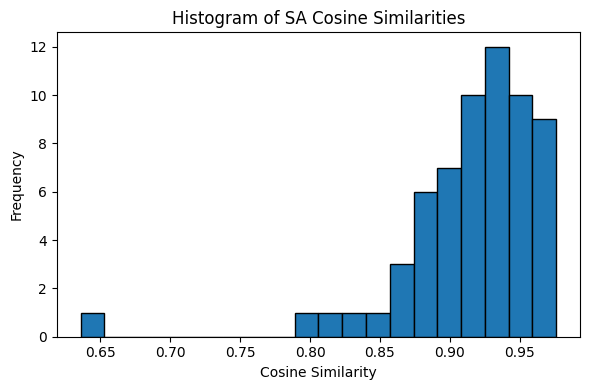

In [83]:
plt.figure(figsize=(6, 4))
plt.hist(sa_values, bins=20, edgecolor='black')
plt.title("Histogram of SA Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("sa_histogram.png")  # Save the histogram as a PNG file
plt.show()
plt.close()  # Close the current figure


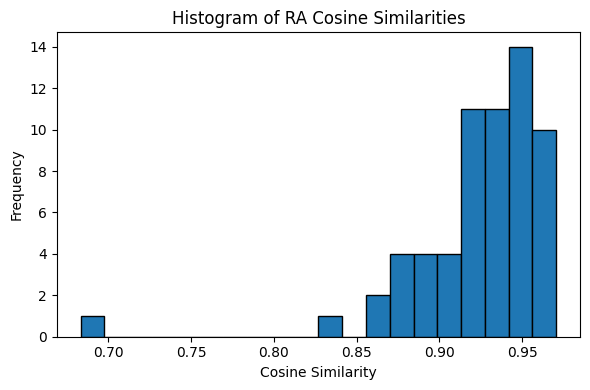

In [84]:
plt.figure(figsize=(6, 4))
plt.hist(ra_values, bins=20, edgecolor='black')
plt.title("Histogram of RA Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("ra_histogram.png")  # Save the histogram as a PNG file
plt.show()
plt.close()  # Close the current figure

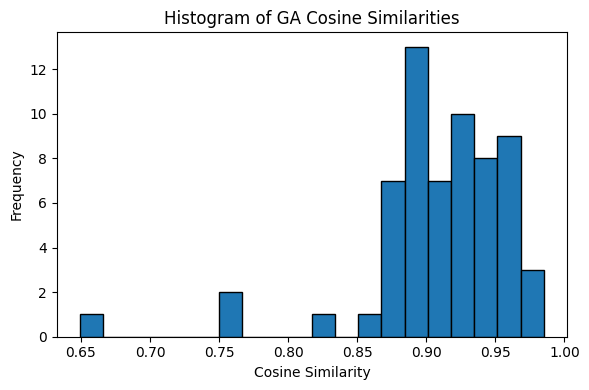

In [85]:
plt.figure(figsize=(6, 4))
plt.hist(ga_values, bins=20, edgecolor='black')
plt.title("Histogram of GA Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("ga_histogram.png")  # Save the histogram as a PNG file
plt.show()
plt.close()  # Close the current figure